# Lab 3: Computational Biology Lab Three


## Part 1: Needleman-Wunsch
The Needleman-Wunsch algorithm is a global sequence alignment algorithm, used to align two sequences by maximizing the similarity between them, using a scoring system. It uses dynamic programming to find the most optimal aligmment between the two sequences based on a given subsitution matrix and an indel/gap penalty. 


In [13]:
import numpy as np

''' The BLOSUM50 matrix is a subsitution matrix that provides similarity scores for amino acid replacements. 
    High scores in BLOSUM50 indicate frequence substitutions, while low scores indicate rare substitutions.
    The BLOSUM50 matrix is a 20x20 matrix, where each entry (i, j) represents the score of replacing amino acid i with amino acid j.'''
def read_blosum_matrix(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        blosum = {} # Dictionary to store subsitution scores
        amino_acids = [] # List to store the amino acid order in the matrix 

        for line in lines:
            # Ignore any comment lines (if any):
            if line.startswith("#"):
                continue
            
            # Split the line into individual values:
            values = line.strip().split()

            # First non-comment row is the header (amino acids labels):
            if not amino_acids:
                if values[0] == 'X':  # Detect and remove 'X' column
                    values = values[1:]  # Skip first column if it is not part of standard BLOSUM
                amino_acids = values # Store amino acid labels
                continue

            # Extract row label, which is the first element in each row:
            row_label = values[0]
            scores = values[1:]  # Ignore the first column (X)

            # Store scores in dictionary, ensuring symmetry:
            for col_label, score in zip(amino_acids, scores):
                try:
                    blosum[(row_label, col_label)] = int(score) # Store subsitution score
                    blosum[(col_label, row_label)] = int(score)  # Ensure symmetric matrix (i.e. blosum[i, j] = blosum[j, i])
                except ValueError:
                    print(f"Error parsing BLOSUM matrix at {row_label}, {col_label}")

    return blosum

''' Load BLOSUM matrix: '''
blosum = read_blosum_matrix("blosum50.txt")
print("BLOSUM matrix loaded successfully.")

# Print first 10 entries of the BLOSUM (Debugging):
print("First 10 entries of the BLOSUM matrix:")
for i, (key, value) in enumerate(blosum.items()):
    if i == 10:
        break
    print(f"{key}: {value}")

BLOSUM matrix loaded successfully.
First 10 entries of the BLOSUM matrix:
('A', 'A'): 5
('A', 'R'): -2
('R', 'A'): -2
('A', 'N'): -1
('N', 'A'): -1
('A', 'D'): -2
('D', 'A'): -2
('A', 'C'): -1
('C', 'A'): -1
('A', 'Q'): -1


In [14]:
import numpy as np

''' The Needleman-Wunsch algorithm is a dynamic programming algorithm that finds the optimal alignment between two sequences.
    The algorithm uses a scoring matrix (e.g. BLOSUM50) to determine the similarity between amino acids.
    The algorithm works by filling a score matrix with the optimal alignment scores, and then tracing back to find the optimal alignment.
    The algorithm also allows for gap penalties, which penalize the alignment for introducing gaps in the sequences.'''
def needleman_wunsch(seq1, seq2, blosum, indel_penalty=-8):
    # We add an additional row and column to fill with gap penalties
    rows, cols = len(seq2) + 1, len(seq1) + 1
    score_matrix = np.zeros((rows, cols))
    traceback = np.full((rows, cols), '')

    # Initialize matrices:
    for i in range(rows):
        # Fill the first column with gap penalties:
        score_matrix[i, 0] = indel_penalty * i
        # Fill the first column with 'U' (up) to indicate that the gap penalty was applied:
        traceback[i, 0] = 'U' if i>0 else ''
    for j in range(cols):
        # Fill the first row with gap penalties:
        score_matrix[0, j] = indel_penalty * j
        # Fill the first row with 'L' (left) to indicate that the gap penalty was applied:
        traceback[0, j] = 'L' if j>0 else ''

    # Fill the score matrix:
    for i in range(1, rows):
        for j in range(1, cols):
            # Define the scoring scheme:
            # Match score: Is dervied from BLOSUM50, which assigns scores for substituting amino acids.
            # Indel penalty: Penalizes the alignment for introducing gaps in the sequences.
            # Mis-match score: Penalizes the alignment for mis-matching amino acids.
            # Left: Represents a gap in the first sequence. 
            # Up: Represents a gap in the second sequence.
            match = blosum.get((seq2[i-1], seq1[j-1]))
            diag = score_matrix[i-1, j-1] + match
            up = score_matrix[i-1, j] + indel_penalty
            left = score_matrix[i, j-1] + indel_penalty

            # Choose the highest scoring move and store it in the score matrix:
            max_score = max(diag, up, left)
            score_matrix[i, j] = max_score

            # Store single direction only:
            if max_score == diag:
                traceback[i, j] = 'D'
            elif max_score == up:
                traceback[i, j] = 'U'
            else:
                traceback[i, j] = 'L'

    # Now, we traceback to find the optimal alignment:
    aligned_seq1, aligned_seq2 = '', ''
    # We start from the bottom right corner:
    i, j = len(seq2), len(seq1)
    scores = [score_matrix[i, j]]

    while i > 0 or j > 0:
        # Now, if we are at a diagonal move, we add the amino acids to the alignment:
        if traceback[i, j] == 'D' and i > 0 and j > 0:
            aligned_seq1 = seq1[j-1] + aligned_seq1
            aligned_seq2 = seq2[i-1] + aligned_seq2
            i -= 1
            j -= 1
        # If we are at an up move, we add a gap to the first sequence:
        elif traceback[i, j] == 'U' or j == 0:
            aligned_seq1 = '-' + aligned_seq1
            aligned_seq2 = seq2[i-1] + aligned_seq2
            i -= 1
        # If we are at a left move, we add a gap to the second sequence:
        else:
            aligned_seq1 = seq1[j-1] + aligned_seq1
            aligned_seq2 = '-' + aligned_seq2
            j -= 1

        # Store the score at each step:
        if i >= 0 and j >= 0:
            scores.append(score_matrix[i, j])

    return aligned_seq1, aligned_seq2, score_matrix, scores[::-1][-1]

    
# Check that it is working using HEAGAWGHEE and PAWHEAE: 
A = "HEAGAWGHEE"
B = "PAWHEAE"

# Run Needleman-Wunsch:
aligned_A, aligned_B, score_matrix, score = needleman_wunsch(A, B, blosum)
print(f"Aligned A: {aligned_A}")
print(f"Aligned B: {aligned_B}")
print(f"Alignment Score: {score}")

# Compare to the result in lecture 13:
expected_A = "HEAGAWGHE-E"
expected_B = "--P-AW-HEAE"
if aligned_A == expected_A and aligned_B == expected_B:
    print("Needleman-Wunsch is working correctly!")

# Match the protein sequences using the above implementation for the following sequences:
C = 'SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL'
D = 'PSPTMEAVTSVEASTASHPHSTSSYFATTYYHLY'
aligned_C, aligned_D, score_matrix, score = needleman_wunsch(C, D, blosum)
print(f"Aligned C: {aligned_C}")
print(f"Aligned D: {aligned_D}")
print(f"Alignment Score: {score}")





Aligned A: HEAGAWGHE-E
Aligned B: --P-AW-HEAE
Alignment Score: 1.0
Needleman-Wunsch is working correctly!
Aligned C: -SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL-
Aligned D: PSPTMEAVTSVEA-STASHPHSTSSYFATTYYHLY
Alignment Score: 7.0


## Part 2: Smith-Waterman Algorithm:


In [15]:
''' The Smith-Waterman Algorithm is a local sequence alignment algorithm that finds the optimal local alignment between two sequences.
    Unlike the Needleman-Wunsch algorithm, which aligns entire sequences, this algorithm only aligns the most relevant matching region.
'''
def smith_waterman(seq1, seq2, blosum, indel_penalty=-8):   
    # Initialize the matrix and the tracing matrix:
    row = len(seq1)
    col = len(seq2) 
    # The scoring matrix is created, where each cell represents the best local alignment score at that position.
    matrix = np.zeros(shape=(row + 1, col + 1))
    tracing_matrix = np.zeros(shape=(row + 1, col +1))

    # Initialize the maximum score and its index:
    max_index = (0 , 0)
    max_score = 0

    # Fill the matrix by calculating the scores for all cells:
    for i in range(1, row + 1):
        for j in range(1, col + 1):

            # Define the schoring scheme:
            # Diagonal/Match-Mismatch score: Is dervied from BLOSUM50, which assigns scores for substituting amino acids.
            # Deletion: Applies a penalty for introducing a gap in the sequence.
            # Insertion: Applies a penalty for introducing a gap in the sequence.  
            match_value = matrix[i-1][j-1] + blosum.get((seq1[i-1], seq2[j-1]), indel_penalty)
            delete = matrix[i-1][j] + indel_penalty
            insert = matrix[i][j-1] + indel_penalty
            # Maximum score is chosen, including a zero for local alignment:
            matrix[i][j] = max(0, match_value, delete, insert)


            # Store traceback directions:

            # If the score is coming from a match/mismatch:
            if matrix[i][j] == match_value:
                tracing_matrix[i][j] = 1 
            # If the score is coming from a deletion:
            elif matrix[i][j] == delete:
                tracing_matrix[i][j] = 2
            # If the score is coming from an insertion:
            elif matrix[i][j] == insert:
                tracing_matrix[i][j] = 3

            # Update the maximum score and its index:
            if matrix[i][j] > max_score:
                max_score = matrix[i][j]
                max_index = (i, j)

    return matrix, tracing_matrix, max_index


def traceback_alignment(seq1, seq2, traceback, max_index):
    # We traceback to reconstruct the most optimal local alignment:
    aligned_seq1 = []
    aligned_seq2 = []
    i, j = max_index
    
    # We start from the cell with the maximum score:
    while traceback[i][j] != 0:
        # If the score is coming from a match/mismatch:
        if traceback[i][j] == 1:
            aligned_seq1.append(seq1[i-1])
            aligned_seq2.append(seq2[j-1])
            i -= 1 # Move diagonally
            j -= 1
        # If the score is coming from a deletion:
        elif traceback[i][j] == 2:
            aligned_seq1.append(seq1[i-1])
            aligned_seq2.append('-')
            i -= 1 # Move up and insert a gap in sequence 2
        # If the score is coming from an insertion:
        elif traceback[i][j] == 3:
            aligned_seq1.append('-')
            aligned_seq2.append(seq2[j-1])
            j -= 1 # Move left and insert a gap in sequence 1

    return ''.join(aligned_seq1[::-1]), ''.join(aligned_seq2[::-1])

# Check that it is working using HEAGAWGHEE and PAWHEAE:
seq1 = 'HEAGAWGHEE'
seq2 = 'PAWHEAE'
score, traceback, max_index = smith_waterman(seq1, seq2, blosum, indel_penalty=-8)
aligned_seq1, aligned_seq2 = traceback_alignment(seq1, seq2, traceback, max_index)
print(f"Aligned A: {aligned_seq1}")
print(f"Aligned B: {aligned_seq2}")
print(f"Alignment Score: {score[max_index[0], max_index[1]]}")



# Compare the result to Lecture 13:
expected_seq2 = 'AW-HE'
expected_seq1 = 'AWGHE'
if aligned_seq1 == expected_seq1 and aligned_seq2 == expected_seq2:
    print("Smith-Waterman is working correctly!")

# Match the protein sequences using the above implementation for the following sequences:
seq3 = 'MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRY'
seq4 = 'TDDECHSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI'
score2, traceback2, max_index2 = smith_waterman(seq3, seq4, blosum, indel_penalty=-8)
aligned_seq3, aligned_seq4 = traceback_alignment(seq3, seq4, traceback2, max_index2)
print(f"Aligned C: {aligned_seq3}")
print(f"Aligned D: {aligned_seq4}")
print(f"Alignment Score: {score2[max_index2[0], max_index2[1]]}")



Aligned A: AWGHE
Aligned B: AW-HE
Alignment Score: 28.0
Smith-Waterman is working correctly!
Aligned C: HSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRI
Aligned D: HSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI
Alignment Score: 273.0


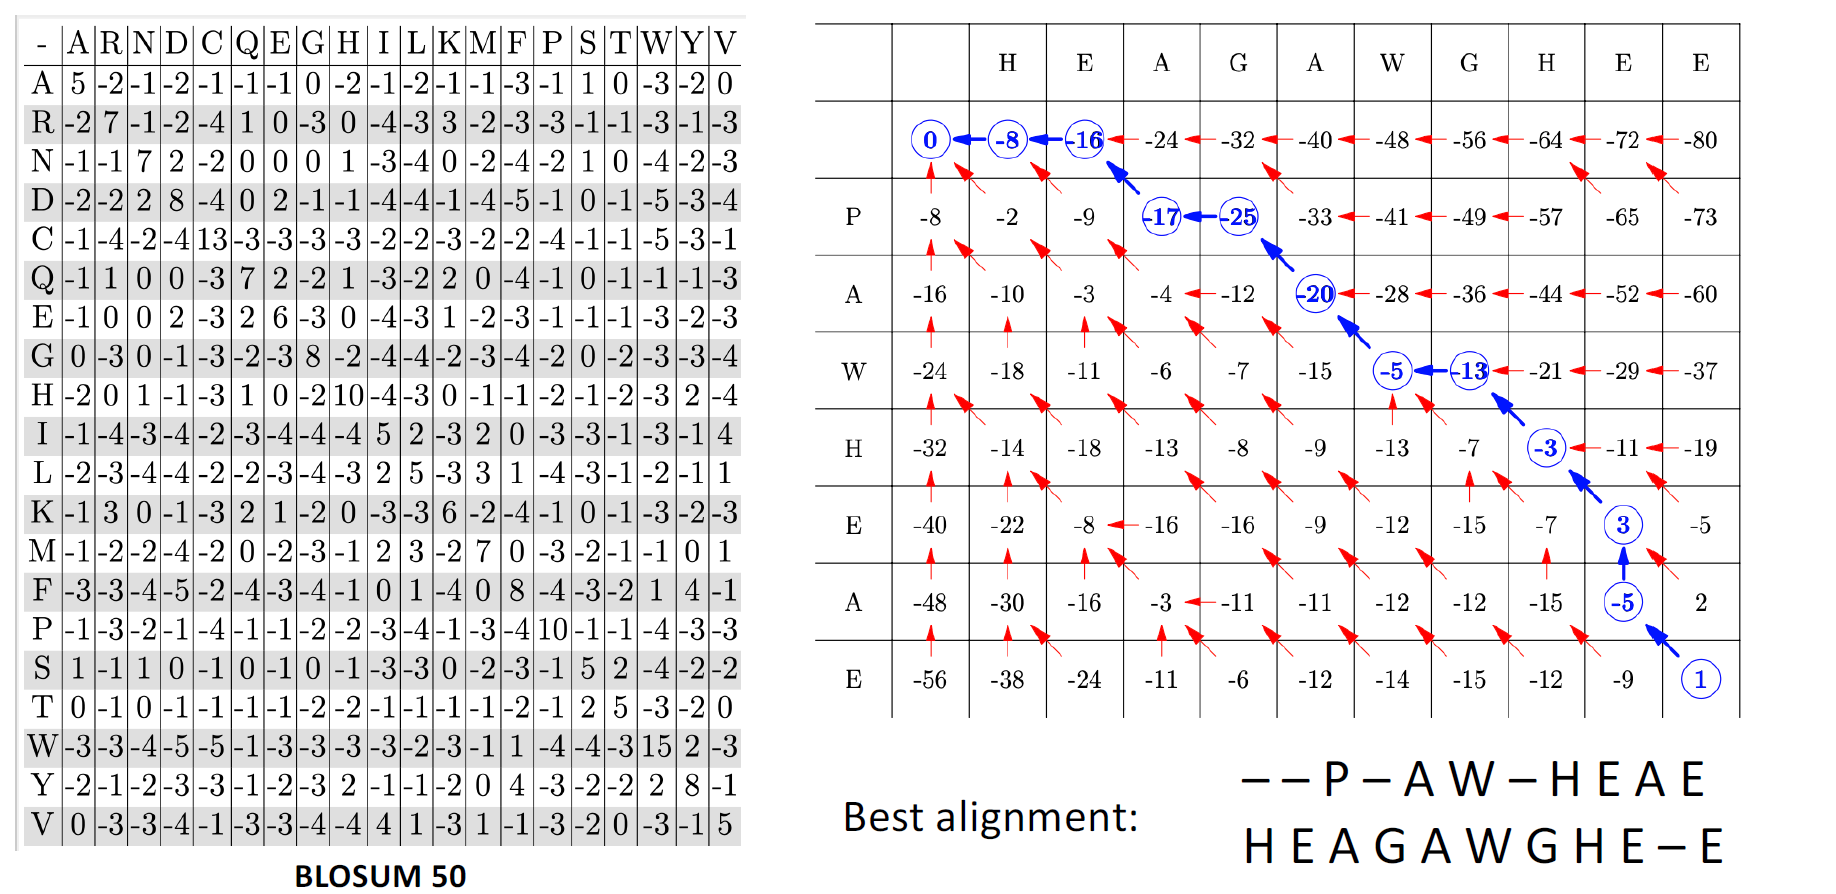

**The differences between Needleman-Wunsch and Smith-Waterman are the following:**
+ Needleman-Wusnch is used to find the best way to align two sequences, even if they don't match perfectly, whereas Smith-Waterman finds the most similar subsequence within the two sequences. 
+ To intialize the matrices, Needleman-Wunsch uses gap penalties, whereas Smith-Waterman starts with zeros. 
+ Negative scores are not allowed in Smith-Waterman and are replaced by zeros. 
+ When tracing back to find the most optimal alginment, Needleman-Wunsch starts from the bottom right corner, whereas Smith-Waterman starts with the cell with the highest score.     

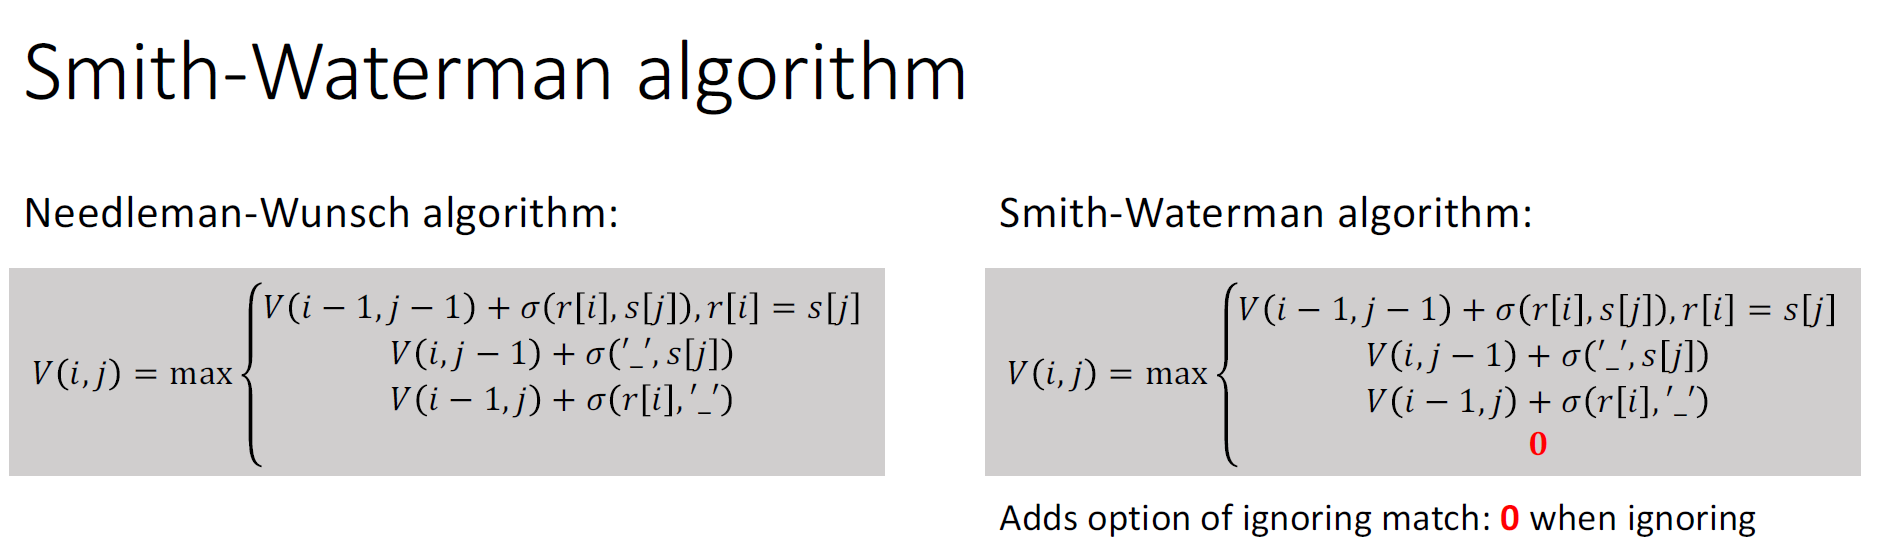

## Part 3: Hidden Markov Models

Dice Rolls:4 2 4 6 6 6 1 5 1 2 5 5 1 6 6 3 6 3 5 6
State Sequence:F F F F L L F F F F F F F L L L L L L L
DNA Sequence: TCTGTTTATC...
State Sequence: ['AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich']...


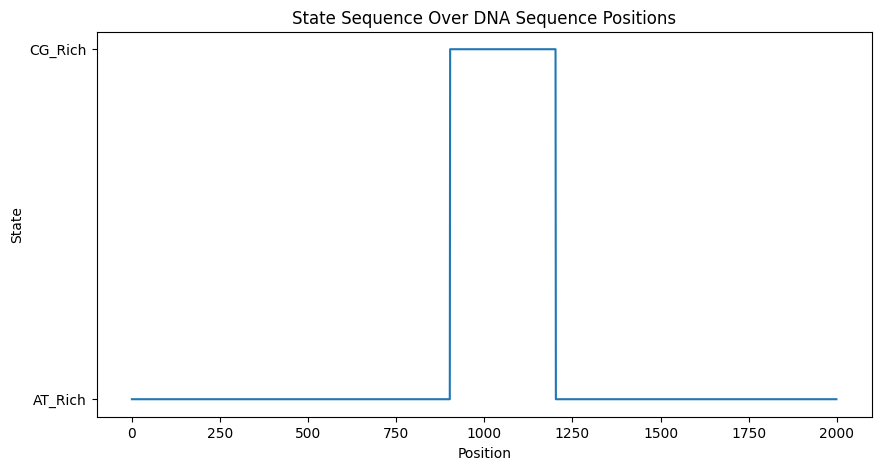

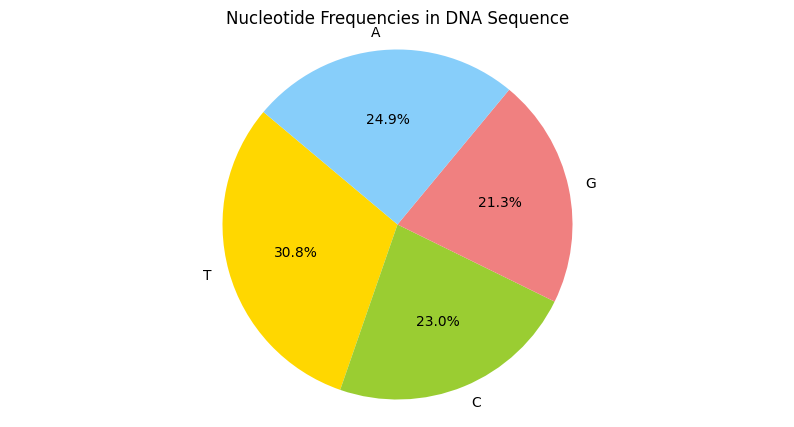

In [16]:
import random

''' Hidden Markov Models are a statistical model used to represent sequences where the underlying states are hidden, but the observations are visible.
'''

''' This function simulates a scenario where a casino occasionaly switches between a fair die and a loaded die. The goal is to generate a sequence of dice rolls and record the state for each of the rolls. '''
def simulate_dishonest_casino(num_rolls=20):

    # Define the two hidden states: F = Fair, L = Loaded.
    states = ['F', 'L']
    
    # Transition probabilities (=The probability of switching from one state to the other):
    #   If the die is fair, it remains fair with probability 0.9 and switches to loaded with probability 0.1.
    #   If the die is loaded, it remains loaded with probability 0.9 and switches to fair with probability 0.1.
    transition = {
        'F': {'F': 0.9, 'L': 0.1},
        'L': {'F': 0.1, 'L': 0.9}
    }
    
    # Emission probabilities(= The probability of generating an observation given the current state):
    #   For a fair die: each number 1-6 is equally likely (1/6).
    #   For a loaded die: the number 6 is more likely (1/2) while numbers 1-5 each have probability 1/10.
    emission = {
        'F': {1: 1/6, 2: 1/6, 3: 1/6, 4: 1/6, 5: 1/6, 6: 1/6},
        'L': {1: 1/10, 2: 1/10, 3: 1/10, 4: 1/10, 5: 1/10, 6: 1/2}
    }
    
    # Initial state, randomly chosen, assuming we start in the fair state.
    current_state = 'F'
    states_sequence = [current_state]
    observations = []
    
    # Generate the first observation based on the initial state.
    # The die is rolled using the emission probabilities for the current state.
    # Determine the next state based on the current state and transition probabilities.
    # Repeat for a specified number of rolls.
    numbers = list(emission[current_state].keys())
    probs = list(emission[current_state].values())
    observation = random.choices(numbers, weights=probs)[0]
    observations.append(observation)
    
    # Simulate the remaining rolls.
    for _ in range(num_rolls - 1):
        # Determine the next state based on the current state and transition probabilities.
        next_state = random.choices(
            population=list(transition[current_state].keys()),
            weights=list(transition[current_state].values())
        )[0]
        current_state = next_state
        states_sequence.append(current_state)
        
        # Generate an observation based on the emission probabilities for the new state.
        numbers = list(emission[current_state].keys())
        probs = list(emission[current_state].values())
        observation = random.choices(numbers, weights=probs)[0]
        observations.append(observation)
    
    return observations, states_sequence

# Run the simulation for a sequence of 20 dice rolls.
observations, states_seq = simulate_dishonest_casino(num_rolls=20)

# Print
print("Dice Rolls:" + " ".join([str(obs) for obs in observations]))
print("State Sequence:" + " ".join(states_seq))


''' This function generates a DNA sequence of a specified length, where the sequence is generated based on a hidden Markov model with two states: AT-rich and CG-rich.'''

def generate_dna_sequence(length=2000):

    # States, which are not directly observable:
    states = ["AT_Rich", "CG_Rich"]
    
    # Start probabilities (from "Start" to each state) (From the Diagram given)
    start_probs = [0.5, 0.5]  # [P(AT_Rich), P(CG_Rich)]
    
    # Transition probabilities (=How likely it is to change between the two states) (row i -> column j):
    # [
    #   [ P(AT->AT),  P(AT->CG) ],
    #   [ P(CG->AT),  P(CG->CG) ]
    # ]
    transition = [
        [0.9998, 0.0002],  # AT_Rich -> [AT_Rich, CG_Rich]
        [0.0003, 0.9997]   # CG_Rich -> [AT_Rich, CG_Rich]
    ]
    
    # Emission probabilities for each state (the probability of emitting a base given the state):
    emissions = {
        "AT_Rich": {"A": 0.2698, "T": 0.3297, "C": 0.2080, "G": 0.1985},
        "CG_Rich": {"A": 0.2459, "T": 0.2079, "C": 0.2478, "G": 0.2984}
    }
    
    # Choose initial state (ranodmly)
    current_state = random.choices(states, weights=start_probs)[0]
    
    # Generate a base based on the chosen initial state
    sequence = []
    states_seq = []
    for _ in range(length):

        states_seq.append(current_state)
        # Emit a base according to the current state's emission probabilities
        # Choose a base randomly based on the emission probabilities for the current state
        bases, base_weights = zip(*emissions[current_state].items())
        emitted_base = random.choices(bases, weights=base_weights)[0]
        sequence.append(emitted_base)
        
        # Transition to the next state
        # Choose the next state based on the transition probabilities for the current state
        if current_state == "AT_Rich":
            next_state = random.choices(states, weights=transition[0])[0]
        else:  # current_state == "CG_Rich"
            next_state = random.choices(states, weights=transition[1])[0]
        current_state = next_state
    
    return "".join(sequence), states_seq

# Generate ~2000 bases
dna_seq, state_seq = generate_dna_sequence(2000)

# Print the first 100 bases
print(f"DNA Sequence: {dna_seq[:10]}...")
print(f"State Sequence: {state_seq[:10]}...")

# Display the results
# A Pie chart of base frequencies for eah state
import matplotlib.pyplot as plt
from collections import Counter

nucleotide_counts = Counter(dna_seq)

labels = nucleotide_counts.keys()
sizes = nucleotide_counts.values()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# Plot the state sequence over the positions in the DNA sequence:
plt.figure(figsize=(10, 5))
plt.plot(state_seq)
plt.xlabel('Position')
plt.ylabel('State')
plt.title('State Sequence Over DNA Sequence Positions')
plt.show()


plt.figure(figsize=(10, 5))
plt.pie (sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Nucleotide Frequencies in DNA Sequence')
plt.show()


















## Part 4: Viterbi Algorithm: 

In [17]:
import numpy as np

''' The Viterbi algorithm is a dynamic programming algorithm that finds the most likely sequence of hidden states given a sequence of observations.
    The algorithm is used in hidden Markov models to predict the most likely sequence of hidden states that generated the observations.'''
def viterbi(observations, states, start_probs, transition_probs, emission_probs):
    n_samples = len(observations)
    n_states = len(states)
    state_indices = {state: i for i, state in enumerate(states)}


    # Initialisation:
    # Viterbi matrix: store the most likely path to each state at each time step.
    # Psi matrix: stores the backpointer (which previous state led to this one)
    # Best path: stores the most likely sequence of states.
    viterbi = np.full((n_states, n_samples), -np.inf) 
    psi = np.zeros((n_states, n_samples), dtype=int)
    best_path = np.zeros(n_samples, dtype=int)

    # Initialization in log-space
    # Forward Pass 
    # The first column is initialized using the prior probability of each state and the probability of emitting the first observation from each state.
    for s, state in enumerate(states):
        viterbi[s, 0] = np.log(start_probs[state] + 1e-10) + np.log(emission_probs[state].get(observations[0], 1e-10))

    # Iterate over time steps:
    for t in range(1, n_samples):
        for s, state in enumerate(states):
            # Compute the most probable previous state using the transtiion probabilities and the emission probabilities.
            # Update the viterbi matrix and the backpointer matrix.
            trans_probs = [viterbi[s_, t-1] + np.log(transition_probs[states[s_]].get(state, 1e-10)) for s_ in range(n_states)]
            psi[s, t], viterbi[s, t] = max(enumerate(trans_probs), key=lambda x: x[1])
            viterbi[s, t] += np.log(emission_probs[state].get(observations[t], 1e-10))  # Add log emission probability

    # Backward Pass 
    # Find the most likely final state: 
    # Start from the most probable last state and trace back to find the most likely sequence of states.
    best_path[-1] = np.argmax(viterbi[:, -1])
    for t in range(n_samples - 1, 0, -1):
        best_path[t-1] = psi[best_path[t], t]

    best_state_sequence = [states[state] for state in best_path]
    return best_state_sequence


states_casino = ['F', 'L']
transition_casino = {
    'F': {'F': 0.9, 'L': 0.1},
    'L': {'F': 0.1, 'L': 0.9}
}
emission_casino = {
    'F': {1: 1/6, 2: 1/6, 3: 1/6, 4: 1/6, 5: 1/6, 6: 1/6},
    'L': {1: 1/10, 2: 1/10, 3: 1/10, 4: 1/10, 5: 1/10, 6: 1/2}
}
priors_casino = {'F': 0.5, 'L': 0.5}  # Equal probability of starting in either state

# Simulate dishonest casino observations
observations_casino = [6, 6, 4, 1, 6, 2, 2, 6, 4, 3, 2, 2, 3, 3, 3, 2, 4, 6, 5, 1, 6, 1, 5, 4, 6, 1, 4, 6, 1, 5, 5, 3, 6, 5, 3, 1, 6, 3, 6, 4, 6, 4, 2, 5, 4, 6, 5, 1, 6, 6, 4, 2, 1, 6, 6, 3, 2, 6, 2, 5, 5, 1, 2, 3, 3, 6, 4, 5, 5, 6, 6, 3, 6, 2, 4, 6, 3, 2, 6, 6, 6, 4, 3, 3, 6, 1, 6, 2, 1, 5, 2, 3, 4, 3, 4, 5, 3, 6, 4, 1]


# Run Viterbi algorithm
predicted_states_casino = viterbi (observations_casino, states_casino, priors_casino, transition_casino, emission_casino)

# Print results
print("Observations: ", observations_casino)
print("Predicted States: ", predicted_states_casino)
print ("Frequency of each state in the predicted states: ", {state: predicted_states_casino.count(state) for state in states_casino})


# Test viterbi on the DNA sequence generator:
states_DNA = ["AT_Rich", "CG_Rich"]
start_probs_DNA = {"AT_Rich": 0.5, "CG_Rich": 0.5}
transition_probs_DNA = {
    "AT_Rich": {"AT_Rich": 0.9998, "CG_Rich": 0.0002},
    "CG_Rich": {"AT_Rich": 0.0003, "CG_Rich": 0.9997}
}
emission_probs_DNA = {
    "AT_Rich": {"A": 0.2698, "T": 0.3297, "C": 0.2080, "G": 0.1985},
    "CG_Rich": {"A": 0.2459, "T": 0.2079, "C": 0.2478, "G": 0.2984}
}

# Generate a DNA sequence
observations_DNA, actual_states_DNA = generate_dna_sequence(2000)

# Run Viterbi algorithm
predicted_states_DNA = viterbi(observations_DNA, states_DNA, start_probs_DNA, transition_probs_DNA, emission_probs_DNA)

# Print results
print("Snippet of Predicted States: ", predicted_states_DNA [:10])
print("Snippet of Actual States: ", actual_states_DNA[:10])
print("Frequency of each state in the actual states: ", {state: actual_states_DNA.count(state) for state in states_DNA})



Observations: 

 [6, 6, 4, 1, 6, 2, 2, 6, 4, 3, 2, 2, 3, 3, 3, 2, 4, 6, 5, 1, 6, 1, 5, 4, 6, 1, 4, 6, 1, 5, 5, 3, 6, 5, 3, 1, 6, 3, 6, 4, 6, 4, 2, 5, 4, 6, 5, 1, 6, 6, 4, 2, 1, 6, 6, 3, 2, 6, 2, 5, 5, 1, 2, 3, 3, 6, 4, 5, 5, 6, 6, 3, 6, 2, 4, 6, 3, 2, 6, 6, 6, 4, 3, 3, 6, 1, 6, 2, 1, 5, 2, 3, 4, 3, 4, 5, 3, 6, 4, 1]
Predicted States:  ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']
Frequency of each state in the predicted states:  {'F': 74, 'L': 26}
Snippet of Predicted States:  ['AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', '

First 100 bases of E. coli sequence: GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCGTCATAACTTAATGTTTTTATTTAAAATACC
First 10 Predicted States:  ['AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich', 'AT_Rich']
Frequency of each state in the predicted states:  {'AT_Rich': 16089, 'CG_Rich': 32413}
Probability of each state in the predicted states:  {'AT_Rich': 0.33171827965857076, 'CG_Rich': 0.6682817203414292}


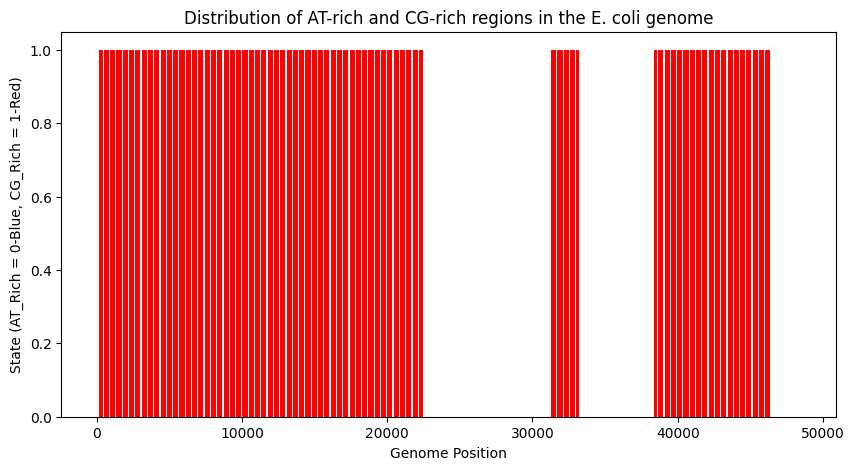

In [18]:
file_path_ecoli = 'enteriobacteriophage.txt'

with open(file_path_ecoli, 'r') as f:
    ecoli_sequence = f.read().replace('\n', '')

print(f"First 100 bases of E. coli sequence: {ecoli_sequence[:100]}")

# Define the states and transition probabilities
states_DNA = ["AT_Rich", "CG_Rich"]
start_probs_DNA = {"AT_Rich": 0.5, "CG_Rich": 0.5}
transition_probs_DNA = {
    "AT_Rich": {"AT_Rich": 0.9997, "CG_Rich": 0.0003},
    "CG_Rich": {"AT_Rich": 0.0002, "CG_Rich": 0.9998}
}
emission_probs_DNA = {
    "AT_Rich": {"A": 0.2698, "T": 0.3237, "C": 0.2080, "G": 0.1985},
    "CG_Rich": {"A": 0.2459, "T": 0.2079, "C": 0.2478, "G": 0.2984}
}

# Convert genome sequence to a list of nucleotides
observations_ecoli = list (ecoli_sequence) 

# Run Viterbi algorithm
predicted_states_ecoli = viterbi(observations_ecoli, states_DNA, start_probs_DNA, transition_probs_DNA, emission_probs_DNA)

# Print results
print("First 10 Predicted States: ", predicted_states_ecoli[:10])
print("Frequency of each state in the predicted states: ", {state: predicted_states_ecoli.count(state) for state in states_DNA})
print ("Probability of each state in the predicted states: ", {state: predicted_states_ecoli.count(state)/len(predicted_states_ecoli) for state in states_DNA})

# Plot the distributuon of AT-rich and CG-rich regions in the E. coli genome:

numeric_states = [0 if state == "AT_Rich" else 1 for state in predicted_states_ecoli]
plt.figure(figsize=(10, 5))
plt.bar(range(len(numeric_states)), numeric_states, color=['blue' if state == 0 else 'red' for state in numeric_states])
plt.title("Distribution of AT-rich and CG-rich regions in the E. coli genome")
plt.xlabel("Genome Position")
plt.ylabel("State (AT_Rich = 0-Blue, CG_Rich = 1-Red)")
plt.show() 


**Resuls from running the Viterbi Algorithm on the Lambda Phage Genome:** 
+ The genome contains more CG-rich segments than AT-rich ones. 
+ This aligns with the fact that many bacteriophages tend to have higher CG content. 
